# Best Places for setting up Chinese Restaurants in New York

Summary of Project:

In this project, I will be using Machine Learning techniques to explore the best locations in New York City to setup a Chinese Restaurant. The intuition behind the project is that certain locations tend to attract more customers because of its surrounding venues (for eg. cinema, airport, etc.). 
    
To setup the classifiers to predict these best spots for Chinese Restaurants, I will have to load and prepare the dataset for training. To do so, I will first explore the various neighborhoods in New York City. Next, using the Foursquare API, I will retrieve all existing Chinese Restaurants in each New York neighborhood along with details like their price tiers. Then, I'll retrieve all nearby venues for each restaurant and one-hot encode them so that I will be able to feed these values as feature vectors into various Machine Learning algorithms, like Logistic Regression and KNN. 
    
Since the aim of the project is to show businesses who are interested in setting up Chinese Restaurants in New York which are the best spots, I will need to create a metric for 'Popularity' to be the outcome vector, y. To do so, I used the Foursquare API to retrieve the 'Likes' count for each Chinese Restaurant in New York and labeled restaurants with likes in the top 25 percentile to be 'Popular' and bottom 25 percentile to be 'Unpopular'. The rest were labeled 'Average'. These labels are needed to be fed as the outcome vector to the classification algorithms.
    
After feeding the feature vectors and popularity outcomes into the models, I will compare the scores (Jaccard Similarity Score, F1-Score, and LogLoss) for each classification algorithm and use the best algorithm to proceed to predict the best locations for Chinese Restaurants in New York.
    
Once a model has been trained, it is time to deploy. I will be retrieving all kinds of venues in New York, such as Accessories Store, American Restaurants, etc., and inputting these venues into the previously trained model. The Machine Learning model will then output the predicted popularity level for each venue. Using these outputs, I will create a map with folium to portray venues with the predicted labels "Popular" along with that of "Unpopular" as the colors blue and red respectively.
    
    

## Import Relevant Libraries

In [1]:
import numpy as np
import matplotlib
import pandas as pd
import os
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
import json
import requests

## Load Dataset

In [2]:
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
with open('newyork_data.json') as ny_data:
    newyork_data = json.load(ny_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
ny_df = pd.DataFrame(columns=column_names)
for neighborhood in neighborhoods_data:
    borough = neighborhood['properties']['borough']
    neighborhood_name = neighborhood['properties']['name']
    latitude = neighborhood['geometry']['coordinates'][1]
    longitude = neighborhood['geometry']['coordinates'][0]
    ny_df = ny_df.append({
        'Borough' : borough,
        'Neighborhood' : neighborhood_name,
        'Latitude' : latitude,
        'Longitude' : longitude,
        },
        ignore_index=True)
ny_df.head(20)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [3]:
print("Shape of the dataframe: ", np.shape(ny_df))
print("Number of unique Boroughs: ", len(ny_df['Borough'].unique()))
print("Number of unique Neighborhoods: ", len(ny_df['Neighborhood'].unique()))

Shape of the dataframe:  (306, 4)
Number of unique Boroughs:  5
Number of unique Neighborhoods:  302


Notice that there are 302 unique Neighborhoods yet there are 306 neighborhoods listed in ny_df.
Now, we will need to explore the dataset to understand why are there duplicated neighborhoods.

## Exploring New York City's Neighborhoods

#### Firstly, identify the duplicated rows.

In [4]:
ny_dup_df = ny_df[ny_df['Neighborhood'].duplicated()]
duplicated_neighborhoods = ny_dup_df['Neighborhood'].tolist()
separator = ", "
print("The neighborhoods which are duplicated are", separator.join(duplicated_neighborhoods))

The neighborhoods which are duplicated are Murray Hill, Sunnyside, Bay Terrace, Chelsea


#### Secondly, create a dataframe ny_dup_df which contains these duplicated rows and sort those with the same neighborhood next to each other for easy comparison.

In [5]:
ny_dup_df = pd.DataFrame(columns=column_names)
for idx, neighborhood in ny_df.iterrows():
    if neighborhood['Neighborhood'] in duplicated_neighborhoods:
        ny_dup_df = ny_dup_df.append({
            'Borough' : neighborhood['Borough'],
            'Neighborhood' : neighborhood['Neighborhood'],
            'Latitude' : neighborhood['Latitude'],
            'Longitude' : neighborhood['Longitude'],
        },
        ignore_index=True)
ny_dup_df.sort_values(by=['Neighborhood'], inplace=True)
ny_dup_df.reset_index(drop=True, inplace=True)
ny_dup_df.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Bay Terrace,40.782843,-73.776802
1,Staten Island,Bay Terrace,40.553988,-74.139166
2,Manhattan,Chelsea,40.744035,-74.003116
3,Staten Island,Chelsea,40.594726,-74.189560
4,Manhattan,Murray Hill,40.748303,-73.978332
5,Queens,Murray Hill,40.764126,-73.812763
6,Queens,Sunnyside,40.740176,-73.926916
7,Staten Island,Sunnyside,40.612760,-74.097126


#### Based on the above dataframe, it is likely that the neighborhoods happen to be a part of two Boroughs. Thus, I will not be removing the duplicated data.

## Visualize Neighborhoods in New York City

In [6]:
# Retrieve New York's latitude & longitude
ny_address = 'New York, United States'
geolocator = Nominatim(user_agent='alalalla')
location = geolocator.geocode(ny_address)
ny_lat = location.latitude
ny_lon = location.longitude
print(ny_lat, ny_lon)

40.7127281 -74.0060152


In [7]:
# Create a map of New York with the neighborhoods superimposed on top.
map_ny = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)
for lat, lon, borough, neighborhood in zip(ny_df['Latitude'], ny_df['Longitude'], ny_df['Borough'], ny_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location=[lat, lon],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#3186cc',
                       fill_opacity=0.7,
                       parse_html=True).add_to(map_ny)

map_ny

## Retrieve Data for Chinese Restaurants in NYC - Foursquare API

In [8]:
CLIENT_ID = "XXXX"
CLIENT_SECRET = "XXXX"
VERSION = "XXXX"

In [9]:
def getRestaurants(names, latitudes, longitudes, category_id, radius=2000):
    """
    Arguments:
    name -- The name of the neighborhood
    latitudes -- The latitude of the neighborhood
    longitudes -- The longitude of the neighborhood
    category_id -- The id of the category of restaurant taken from foursquare docs
    radius -- The radius of restaurants within the input latitude and longitude in metres.
    
    Returns:
    df -- A dataframe with the columns 'Neighborhood', 'Restaurant ID', 'Restaurant Name', 
          'Restaurant Latitude', 'Restaurant Longitude', 'Restaurant Latitude
          and Longitude'
    """
    LIMIT = 100
    column_names = ['Neighborhood', 'Restaurant ID', 'Restaurant Name', 'Restaurant Latitude', 'Restaurant Longitude', 'Restaurant Latitude and Longitude']
    df = pd.DataFrame(columns=column_names)
    for name, lat, lon in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                VERSION,
                lat,
                lon,
                radius,
                category_id)
        results = requests.get(url).json()
        try:
            restaurant_id = results['response']['venues'][0]['id']
            restaurant_name = results['response']['venues'][0]['name']
            restaurant_lat = results['response']['venues'][0]['location']['lat']
            restaurant_lon = results['response']['venues'][0]['location']['lng']
            df = df.append({
                    'Neighborhood' : name,
                    'Restaurant ID' : restaurant_id,
                    'Restaurant Name' : restaurant_name,
                    'Restaurant Latitude' : restaurant_lat,
                    'Restaurant Longitude' : restaurant_lon,
                    'Restaurant Latitude and Longitude' : (restaurant_lat, restaurant_lon)
                    }, ignore_index=True)
        except:
            pass
    return df

#### Retrieve coordinates of Chinese Restaurants in each NYC neighborhood

In [10]:
chinese_restaurants_category_id = '4bf58dd8d48988d145941735'
chinese_restaurant_df = getRestaurants(ny_df['Neighborhood'], ny_df['Latitude'], ny_df['Longitude'], chinese_restaurants_category_id)

In [11]:
chinese_restaurant_df.sort_values(by=['Neighborhood'], inplace=True)
chinese_restaurant_df.reset_index(drop=True, inplace=True)
chinese_restaurant_df.head()

,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Restaurant Latitude and Longitude
0,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,"(40.861789, -73.85732900000001)"
1,Annadale,4cafb11eeb65b1f79de365cd,China Chalet,40.545628,-74.175967,"(40.54562814140674, -74.17596683734693)"
2,Arden Heights,4bb23577715eef3be6e984bb,Peking Taste of Arden,40.553302,-74.192674,"(40.553301575857574, -74.19267379243564)"
3,Arlington,4b69eeedf964a520debc2be3,Great China Restaurant,40.626383,-74.161346,"(40.626383000000004, -74.161346)"
4,Arrochar,57e84177cd10e174a054424d,Dragon House Chinese Sand Lane,40.593718,-74.068828,"(40.593718, -74.068828)"


In [12]:
print("Number of Chinese restaurants: ", np.shape(chinese_restaurant_df)[0])
print("Number of unique neighborhoods: ", len(chinese_restaurant_df['Neighborhood'].unique()))
print("Number of unique restaurants by ID: ", len(chinese_restaurant_df['Restaurant ID'].unique()))
print("Number of unique Chinese restaurants by name: ",len(chinese_restaurant_df['Restaurant Name'].unique()))
print("Number of unique Chinese restaurants by location: ", len(chinese_restaurant_df['Restaurant Latitude and Longitude'].unique()))

Number of Chinese restaurants:  304
Number of unique neighborhoods:  300
Number of unique restaurants by ID:  270
Number of unique Chinese restaurants by name:  255
Number of unique Chinese restaurants by location:  270


#### By comparing the number of unique Chinese restaurants by ID and location (270) and the number of unique neighborhoods (300), I can hypothesize that some neighborhoods do not have a Chinese restaurant.

#### Also, notice that while the number of unique Chinese restaurants by name is 255, the unique count by ID is 270. Thus, it is likely that some Chinese restaurants have the same name, yet are not referring to the same restaurants since they have different IDs and are located at different places.

#### Now, I will create a new unique_chinese_restaurant_df from the chinese_restaurant_df after removing duplicated restaurants by ID.

In [13]:
unique_chinese_restaurant_df = chinese_restaurant_df.drop_duplicates(subset=['Restaurant ID'], keep='first')
unique_chinese_restaurant_df.reset_index(drop=True, inplace=True)
unique_chinese_restaurant_df = unique_chinese_restaurant_df.sort_values(by=['Neighborhood'])
print("Number of duplicated restaurants removed: ", np.shape(chinese_restaurant_df)[0] - np.shape(unique_chinese_restaurant_df)[0])
print("Chinese Restaurants unique by ID: ", np.shape(unique_chinese_restaurant_df)[0])
unique_chinese_restaurant_df.head()

Number of duplicated restaurants removed:  34
Chinese Restaurants unique by ID:  270


,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Restaurant Latitude and Longitude
0,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,"(40.861789, -73.85732900000001)"
1,Annadale,4cafb11eeb65b1f79de365cd,China Chalet,40.545628,-74.175967,"(40.54562814140674, -74.17596683734693)"
2,Arden Heights,4bb23577715eef3be6e984bb,Peking Taste of Arden,40.553302,-74.192674,"(40.553301575857574, -74.19267379243564)"
3,Arlington,4b69eeedf964a520debc2be3,Great China Restaurant,40.626383,-74.161346,"(40.626383000000004, -74.161346)"
4,Arrochar,57e84177cd10e174a054424d,Dragon House Chinese Sand Lane,40.593718,-74.068828,"(40.593718, -74.068828)"


## Further retrieve and enrich the dataset for Chinese Restaurants in NYC

Using the foursquare API, I will retrieve the number of likes, ratings, and price for each restaurant.

In [14]:
def getRestaurantDetails(neighborhoods, restaurant_ids, restaurant_names):
    """
    Parameters:
    neighborhoods    -- Name of neighborhood the restaurant is in
    restaurant_ids   -- Foursquare restaurant's unique ID
    restaurant_names -- Name of the restaurant
    
    Returns:
    df -- A dataframe with the columns 'Neighborhood', 'Restaurant ID', 
          'Restaurant Name', 'Likes', 'Ratings', 'Price Tier'.
          
          Columns:
          'Likes'      -- Count of number of users who have "liked" the place
          'Ratings'    -- Numerical rating of the venue (0 through 10). Returned as part of
                          an explore result, excluded in search results. Not all venues will 
                          have a rating.
          'Price Tier' -- An object containing the price tier from 1 (least pricey) - 4 
                          (most pricey) and a message describing the price tier.
    
    """
    column_names = ['Neighborhood', 'Restaurant ID', 'Restaurant Name', 'Likes', 'Ratings', 'Price Tier']
    df = pd.DataFrame(columns=column_names)
    for neighborhood, restaurant_id, restaurant_name in zip(neighborhoods, restaurant_ids, restaurant_names):
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            restaurant_id,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
        )
        results = requests.get(url).json()
        try:
            restaurant_likes = results['response']['venue']['likes']['count']
        except:
            restaurant_likes = np.nan
        try:
            restaurant_price = results['response']['venue']['price']['tier']
        except:
            restaurant_price = np.nan
        try:
            restaurant_rating = results['response']['venue']['rating']
        except:
            restaurant_rating = np.nan
        df = df.append({
                'Neighborhood' : neighborhood,
                'Restaurant ID' : restaurant_id,
                'Restaurant Name' : restaurant_name,
                'Likes' : restaurant_likes,
                'Ratings' : restaurant_rating,
                'Price Tier' : restaurant_price
                }, ignore_index=True)
    return df

In [15]:
chinese_restaurant_details_df = getRestaurantDetails(unique_chinese_restaurant_df['Neighborhood'], unique_chinese_restaurant_df['Restaurant ID'], unique_chinese_restaurant_df['Restaurant Name'])

In [16]:
print("Number of rows in chinese_restaurant_details_df: ", np.shape(chinese_restaurant_details_df)[0])
print("Number of unique restaurants by ID: ", len(chinese_restaurant_details_df['Restaurant ID'].unique()))
print("chinese_restaurant_details_df dataframe: ")
chinese_restaurant_details_df.head()

Number of rows in chinese_restaurant_details_df:  270
Number of unique restaurants by ID:  270
chinese_restaurant_details_df dataframe: 


,Neighborhood,Restaurant ID,Restaurant Name,Likes,Ratings,Price Tier
0,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,0,NaN,1
1,Annadale,4cafb11eeb65b1f79de365cd,China Chalet,0,NaN,1
2,Arden Heights,4bb23577715eef3be6e984bb,Peking Taste of Arden,4,NaN,1
3,Arlington,4b69eeedf964a520debc2be3,Great China Restaurant,1,NaN,1
4,Arrochar,57e84177cd10e174a054424d,Dragon House Chinese Sand Lane,0,NaN,1


#### Now, we merge the dataframes chinese_restaurant_details_df and unique_chinese_restaurant_df together to create chinese_restaurant_df which comprises of the Likes, Ratings, and Price Tier for each unique Chinese Restaurant based on Restaurant ID.

In [17]:
chinese_restaurant_df = unique_chinese_restaurant_df.merge(right=chinese_restaurant_details_df, how='left',on=['Neighborhood', 'Restaurant ID', 'Restaurant Name'])
chinese_restaurant_df = chinese_restaurant_df.drop(axis=1, columns='Restaurant Latitude and Longitude')
chinese_restaurant_df.head(10)

,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Likes,Ratings,Price Tier
0,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,0,NaN,1
1,Annadale,4cafb11eeb65b1f79de365cd,China Chalet,40.545628,-74.175967,0,NaN,1
2,Arden Heights,4bb23577715eef3be6e984bb,Peking Taste of Arden,40.553302,-74.192674,4,NaN,1
3,Arlington,4b69eeedf964a520debc2be3,Great China Restaurant,40.626383,-74.161346,1,NaN,1
4,Arrochar,57e84177cd10e174a054424d,Dragon House Chinese Sand Lane,40.593718,-74.068828,0,NaN,1
5,Arverne,58d8228324ca6a0165df2108,Happy Wok,40.592908,-73.795996,0,NaN,1
6,Astoria,4aa9b377f964a520f15420e3,Golden House Chinese Restaurant,40.765193,-73.917760,3,7.0,1
7,Astoria Heights,4f3234e019836c91c7c0a983,Chop Sticks Chinese,40.770495,-73.892211,3,NaN,1
8,Auburndale,5ccdcfe0ea1e44002c866144,Yummy Noodle House 粥麵之家,40.766617,-73.789791,4,7.4,NaN
9,Bath Beach,5b5fa5476dcf04003993a767,Mr. Bun 包大人,40.603852,-73.997109,5,NaN,1


## Explore the dataset for Chinese Restaurants in NYC

In [18]:
chinese_restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270 entries, 0 to 269
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Neighborhood          270 non-null    object 
 1   Restaurant ID         270 non-null    object 
 2   Restaurant Name       270 non-null    object 
 3   Restaurant Latitude   270 non-null    float64
 4   Restaurant Longitude  270 non-null    float64
 5   Likes                 270 non-null    object 
 6   Ratings               99 non-null     float64
 7   Price Tier            254 non-null    object 
dtypes: float64(3), object(5)
memory usage: 19.0+ KB


In [19]:
chinese_restaurant_df[['Likes']].describe()

,Likes
count,270
unique,56
top,0
freq,62


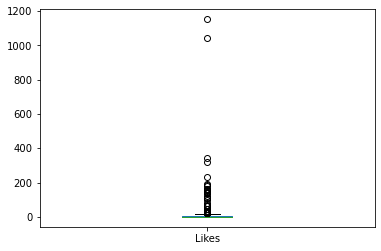

In [20]:
chinese_restaurant_df[['Likes']].plot.box()

In [21]:
chinese_restaurant_df[['Price Tier']].describe()

,Price Tier
count,254
unique,3
top,1
freq,213


In [22]:
chinese_restaurant_df[['Ratings']].describe()

,Ratings
count,99.000000
mean,7.260606
std,0.912925
min,5.200000
25%,6.600000
50%,7.300000
75%,7.900000
max,9.100000


#### Create the dataframe with the normalized values of the top 10 most liked Chinese Restaurants in New York City.

In [23]:
most_liked_restaurants = chinese_restaurant_df.sort_values(by=['Likes'], ascending=False)[0:10]
normalize_restaurant = most_liked_restaurants[['Likes', 'Ratings', 'Price Tier']]
min_max_scaler = preprocessing.MinMaxScaler()
restaurants_scaled = min_max_scaler.fit_transform(normalize_restaurant.values)
restaurants_scaled_df = pd.DataFrame(columns=['Norm Likes', 'Norm Ratings', 'Norm Price Tier'])
restaurants_scaled_df = pd.DataFrame({'Norm Likes' : restaurants_scaled[:, 0],
                                      'Norm Ratings' : restaurants_scaled[:, 1],
                                      'Norm Price Tier' : restaurants_scaled[:, 2],
                                     }, index=most_liked_restaurants.index)
most_liked_restaurants_df = most_liked_restaurants.join(other=restaurants_scaled_df, how='left')
most_liked_restaurants_df.reset_index(drop=True, inplace=True)
most_liked_restaurants_df.head(10)

,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Likes,Ratings,Price Tier,Norm Likes,Norm Ratings,Norm Price Tier
0,Gramercy,52169fba11d21db81bdab2a0,Han Dynasty,40.732130,-73.988090,1152,8.8,2,1.000000,0.923077,1.0
1,Midtown South,4e3484038877beb5e9a22a0b,Café China,40.749980,-73.982234,1045,8.7,2,0.892028,0.846154,1.0
2,North Side,58df00318cfe546addb99246,Birds of a Feather,40.714262,-73.960572,342,8.9,1,0.182644,1.000000,0.0
3,Upper West Side,5529bfd8498ec6ce692d8015,Han Dynasty,40.787620,-73.976359,322,8.7,2,0.162462,0.846154,1.0
4,South Side,3fd66200f964a5206bf11ee3,M Shanghai Bistro,40.713022,-73.957521,230,7.6,2,0.069627,0.000000,1.0
5,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快餐店,40.717278,-73.994177,193,8.5,1,0.032291,0.692308,0.0
6,Chelsea,56b4157d498e3b7e896370d8,Very Fresh Noodles,40.742108,-74.005575,187,8.0,2,0.026236,0.307692,1.0
7,Battery Park City,4a1d6741f964a520727b1fe3,Fish Market,40.707050,-74.001808,178,8.5,1,0.017154,0.692308,0.0
8,Greenwich Village,58a4fb9d30ecc618cdd5c3e2,Pinch Chinese,40.726357,-74.001948,163,7.7,1,0.002018,0.076923,0.0
9,Downtown,59da9590e1f0aa52976b8f35,Han Dynasty,40.691334,-73.982456,161,8.3,1,0.000000,0.538462,0.0


#### Plot a bar graph showing the top 10 most liked restaurant.

Text(0, 0.5, 'Normalized Values for Likes, Ratings, and Price Tier')

/Users/vico/anaconda/envs/capstone/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33775 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/vico/anaconda/envs/capstone/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35920 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/vico/anaconda/envs/capstone/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24555 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/vico/anaconda/envs/capstone/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39184 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/vico/anaconda/envs/capstone/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/vico/anaconda/envs

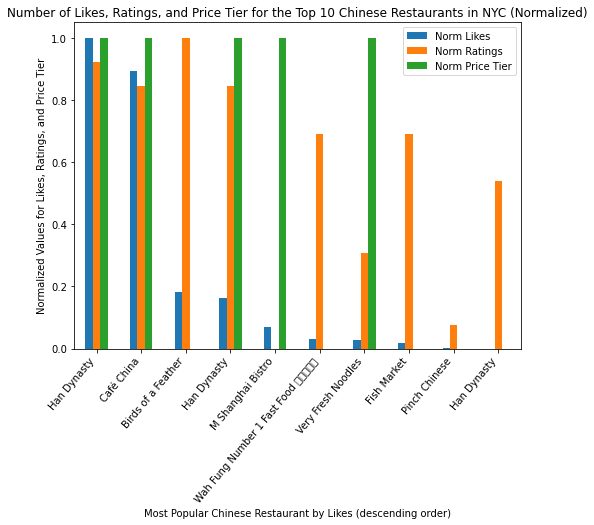

In [24]:
most_liked_restaurants_df[['Norm Likes', 'Norm Ratings', 'Norm Price Tier']].plot(kind='bar', figsize=(8,6))
plt.title("Number of Likes, Ratings, and Price Tier for the Top 10 Chinese Restaurants in NYC (Normalized)")
plt.xticks(range(0, len(most_liked_restaurants_df.index)), most_liked_restaurants_df['Restaurant Name'].to_list())
plt.xticks(rotation=50, horizontalalignment='right')
plt.xlabel("Most Popular Chinese Restaurant by Likes (descending order)")
plt.ylabel("Normalized Values for Likes, Ratings, and Price Tier")

#### Since more than half of the column "Ratings" are null values, I will remove the column as it does not add much value to training a model.

In [25]:
chinese_restaurant_df = chinese_restaurant_df.drop(axis=1, columns=['Ratings'])
# Swap the column Likes and Price Tier
chinese_restaurant_df = chinese_restaurant_df[['Neighborhood', 'Restaurant ID', 'Restaurant Name', 'Restaurant Latitude', 'Restaurant Longitude', 'Price Tier', 'Likes']]
chinese_restaurant_df.head()

,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Price Tier,Likes
0,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,1,0
1,Annadale,4cafb11eeb65b1f79de365cd,China Chalet,40.545628,-74.175967,1,0
2,Arden Heights,4bb23577715eef3be6e984bb,Peking Taste of Arden,40.553302,-74.192674,1,4
3,Arlington,4b69eeedf964a520debc2be3,Great China Restaurant,40.626383,-74.161346,1,1
4,Arrochar,57e84177cd10e174a054424d,Dragon House Chinese Sand Lane,40.593718,-74.068828,1,0


#### Now we need to handle all the null values. Using linear regression, identify if there is a strong relationship between the outcome y (Likes) and ratings and price tier

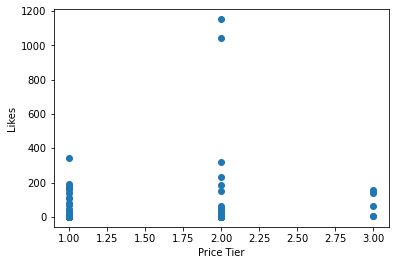

In [26]:
# plt.plot(kind="scatter", x=chinese_restaurant_df['Price Tier'], y=chinese_restaurant_df['Likes'])
temp_df = chinese_restaurant_df.dropna(axis=0, how='any')
temp_df.plot.scatter(x='Price Tier', y='Likes')
plt.plot(temp_df['Price Tier'], temp_df['Likes'], 'o')
plt.plot
plt.show()

#### Since it does not seem as though Price Tier and Likes are strongly correlated, I will not be filling up the missing Price Tier rows via prediction by a best fit line. Instead, I will drop the rows with missing Price Tier and Likes.

In [27]:
chinese_restaurant_df = chinese_restaurant_df.dropna(axis=0, how='any').reset_index()
chinese_restaurant_df

,index,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Price Tier,Likes
0,0,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,1,0
1,1,Annadale,4cafb11eeb65b1f79de365cd,China Chalet,40.545628,-74.175967,1,0
2,2,Arden Heights,4bb23577715eef3be6e984bb,Peking Taste of Arden,40.553302,-74.192674,1,4
3,3,Arlington,4b69eeedf964a520debc2be3,Great China Restaurant,40.626383,-74.161346,1,1
4,4,Arrochar,57e84177cd10e174a054424d,Dragon House Chinese Sand Lane,40.593718,-74.068828,1,0
...,...,...,...,...,...,...,...,...
249,265,Wingate,4bf1e92d189f0f470edbb762,China Pavilion,40.668345,-73.936936,1,0
250,266,Woodhaven,4daca97e8154e1a040dc8749,Hong Kong Gourmet,40.692272,-73.859337,1,2
251,267,Woodlawn,4c65a8fb19f3c9b641c09dff,Dragon China,40.903224,-73.865817,1,1
252,268,Woodside,4ae1d8b2f964a520e78721e3,Peking BBQ Chicken,40.745488,-73.906053,1,47


In [28]:
chinese_restaurant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 254 non-null    int64  
 1   Neighborhood          254 non-null    object 
 2   Restaurant ID         254 non-null    object 
 3   Restaurant Name       254 non-null    object 
 4   Restaurant Latitude   254 non-null    float64
 5   Restaurant Longitude  254 non-null    float64
 6   Price Tier            254 non-null    object 
 7   Likes                 254 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 16.0+ KB


## Retrieve Chinese Restaurant's Nearby Venues

#### These venues would then be one-hot encoded and fed to various machine learning models below to predict, based on a restaurant's location and surrounding venues (e.g. Airport, African Restaurant, ...), the popularity of a restaurant.

#### The term "popularity" will be further defined below.

In [29]:
def getNearbyVenues(neighborhoods, restaurant_ids, restaurant_names, latitudes, longitudes, radius=1000):
    LIMIT=300
    venues_list = []
    for neighborhood, rest_id, name, lat, lon in zip(neighborhoods, restaurant_ids, restaurant_names, latitudes, longitudes):
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&radius={}&v={}".format(
                CLIENT_ID,
                CLIENT_SECRET,
                lat,
                lon,
                radius,
                VERSION
                )
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(
            neighborhood,
            rest_id,
            name,
            lat,
            lon,
            v['venue']['id'],
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    column_names = ['Neighborhood', 'Restaurant ID', 'Restaurant Name', 'Restaurant Latitude', 'Restaurant Longitude', 'Venue ID', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue], columns=column_names)

    return nearby_venues

In [30]:
df = chinese_restaurant_df
restaurant_nearby_venues = getNearbyVenues(df['Neighborhood'], df['Restaurant ID'], df['Restaurant Name'], df['Restaurant Latitude'], df['Restaurant Longitude'])

In [31]:
restaurant_nearby_venues

,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,4c76e7da947ca1cd26c14537,Sal & Doms Bakery,40.865377,-73.855236,Dessert Shop
1,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,4cbf2e697dc9a0930f5e37f5,Domenick's Pizzeria,40.865576,-73.858124,Pizza Place
2,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,51cca5f5498e2220a7f4f0cf,Peach Wave,40.856051,-73.855706,Frozen Yogurt Shop
3,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,4bd3b74eb221c9b6a980dad0,White Castle,40.866065,-73.862307,Fast Food Restaurant
4,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,4c2cff8075579521c6555d83,Bronx Martial Arts Academy,40.865721,-73.857529,Martial Arts Dojo
...,...,...,...,...,...,...,...,...,...,...
7494,Yorkville,4b53bfb3f964a5202daa27e3,Charley Mom,40.774154,-73.948486,4fe0eda4e4b0085f8737a2cc,The Penrose,40.775444,-73.953143,Gastropub
7495,Yorkville,4b53bfb3f964a5202daa27e3,Charley Mom,40.774154,-73.948486,4b2fbd84f964a520dfee24e3,Schaller & Weber,40.777680,-73.951929,Butcher
7496,Yorkville,4b53bfb3f964a5202daa27e3,Charley Mom,40.774154,-73.948486,4b33ace6f964a5209e1c25e3,Agata & Valentina UES Market,40.772002,-73.952997,Grocery Store
7497,Yorkville,4b53bfb3f964a5202daa27e3,Charley Mom,40.774154,-73.948486,557ef6b8498e8dd048cea0db,Schaller's Stube Sausage Bar,40.777588,-73.951975,Hot Dog Joint


In [32]:
restaurant_nearby_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7499 entries, 0 to 7498
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Neighborhood          7499 non-null   object 
 1   Restaurant ID         7499 non-null   object 
 2   Restaurant Name       7499 non-null   object 
 3   Restaurant Latitude   7499 non-null   float64
 4   Restaurant Longitude  7499 non-null   float64
 5   Venue ID              7499 non-null   object 
 6   Venue                 7499 non-null   object 
 7   Venue Latitude        7499 non-null   float64
 8   Venue Longitude       7499 non-null   float64
 9   Venue Category        7499 non-null   object 
dtypes: float64(4), object(6)
memory usage: 586.0+ KB


In [33]:
restaurant_nearby_venues.groupby('Restaurant ID').count()

,Neighborhood,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
Restaurant ID,,,,,,,,,
3fd66200f964a5206bf11ee3,30,30,30,30,30,30,30,30,30
3fd66200f964a52099e61ee3,30,30,30,30,30,30,30,30,30
3fd66200f964a520adea1ee3,30,30,30,30,30,30,30,30,30
49d6a64cf964a520f45c1fe3,30,30,30,30,30,30,30,30,30
4a1d6741f964a520727b1fe3,30,30,30,30,30,30,30,30,30
...,...,...,...,...,...,...,...,...,...
5d62af746d30980007d08784,30,30,30,30,30,30,30,30,30
5d93be2f185535000866cf7d,30,30,30,30,30,30,30,30,30
5de091bb5bf5aa0008cbe106,30,30,30,30,30,30,30,30,30


#### Insert the columns "Neighborhood", "Restaurant Longitude", "Restaurant Latitude", "Restaurant Name", "Restaurant ID" and "Neighborhood" into a onehot-encoded dataframe comprising of all nearby venues for each Chinese Restaurant in NYC.

In [34]:
newyork_onehot = pd.get_dummies(restaurant_nearby_venues[['Venue Category']], prefix= "", prefix_sep="")
newyork_onehot.drop(axis=1, columns=['Neighborhood'], inplace=True)
newyork_onehot.insert(loc=0, column='Restaurant Longitude', value=restaurant_nearby_venues['Restaurant Longitude'])
newyork_onehot.insert(loc=0, column='Restaurant Latitude', value=restaurant_nearby_venues['Restaurant Latitude'])
newyork_onehot.insert(loc=0, column='Restaurant Name', value=restaurant_nearby_venues['Restaurant Name'])
newyork_onehot.insert(loc=0, column='Restaurant ID', value=restaurant_nearby_venues['Restaurant ID'])
newyork_onehot.insert(loc=0, column='Neighborhood', value=restaurant_nearby_venues['Neighborhood'])

In [35]:
newyork_onehot

,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,...,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Allerton,4d225dea756e8cfa7d1e7e54,New Happy Garden,40.861789,-73.857329,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,Yorkville,4b53bfb3f964a5202daa27e3,Charley Mom,40.774154,-73.948486,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7495,Yorkville,4b53bfb3f964a5202daa27e3,Charley Mom,40.774154,-73.948486,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7496,Yorkville,4b53bfb3f964a5202daa27e3,Charley Mom,40.774154,-73.948486,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7497,Yorkville,4b53bfb3f964a5202daa27e3,Charley Mom,40.774154,-73.948486,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, combine the onehot encoding for each Chinese Restaurant such that each row in the dataframe represents one restaurant and for each venue that is in the restaurant's vicinity, there will be a value under the respective column.

In [36]:
temp_df = newyork_onehot.drop(axis=1, columns=['Neighborhood', 'Restaurant Name', 'Restaurant Latitude', 'Restaurant Longitude'])
newyork_grouped = temp_df.groupby('Restaurant ID').mean()
newyork_grouped.reset_index(inplace=True)
newyork_grouped.insert(loc=1, column='Restaurant Longitude', value=chinese_restaurant_df['Restaurant Longitude'])
newyork_grouped.insert(loc=1, column='Restaurant Latitude', value=chinese_restaurant_df['Restaurant Latitude'])
newyork_grouped.insert(loc=1, column='Restaurant Name', value=chinese_restaurant_df['Restaurant Name'])
newyork_grouped.insert(loc=0, column='Neighborhood', value=chinese_restaurant_df['Neighborhood'])
newyork_grouped.insert(loc=len(newyork_grouped.columns), column='Price Tier', value=chinese_restaurant_df['Price Tier'])
newyork_grouped.insert(loc=len(newyork_grouped.columns), column='Likes', value=chinese_restaurant_df['Likes'])
newyork_grouped

,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Price Tier,Likes
0,Allerton,3fd66200f964a5206bf11ee3,New Happy Garden,40.861789,-73.857329,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.100000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1,0
1,Annadale,3fd66200f964a52099e61ee3,China Chalet,40.545628,-74.175967,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.066667,0.000000,0.0,0.033333,0.000000,0.0,0.0,1,0
2,Arden Heights,3fd66200f964a520adea1ee3,Peking Taste of Arden,40.553302,-74.192674,0.0,0.033333,0.000000,0.0,0.0,...,0.0,0.000000,0.033333,0.0,0.000000,0.066667,0.0,0.0,1,4
3,Arlington,49d6a64cf964a520f45c1fe3,Great China Restaurant,40.626383,-74.161346,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.033333,0.033333,0.0,0.000000,0.066667,0.0,0.0,1,1
4,Arrochar,4a1d6741f964a520727b1fe3,Dragon House Chinese Sand Lane,40.593718,-74.068828,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,Wingate,5d62af746d30980007d08784,China Pavilion,40.668345,-73.936936,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1,0
250,Woodhaven,5d93be2f185535000866cf7d,Hong Kong Gourmet,40.692272,-73.859337,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1,2
251,Woodlawn,5de091bb5bf5aa0008cbe106,Dragon China,40.903224,-73.865817,0.0,0.000000,0.033333,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1,1
252,Woodside,5ded9c83bed40a0007bfc5a7,Peking BBQ Chicken,40.745488,-73.906053,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.0,0.0,1,47


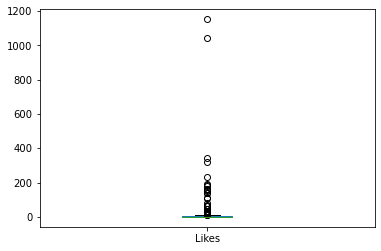

In [37]:
newyork_grouped['Likes'].plot(kind='box')

In [38]:
newyork_grouped = newyork_grouped.sort_values(by='Likes', ascending='False')
newyork_grouped = newyork_grouped.reset_index(drop=True)
newyork_grouped

,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Price Tier,Likes
0,Allerton,3fd66200f964a5206bf11ee3,New Happy Garden,40.861789,-73.857329,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.1,0.000000,0.0,0.0,0.000000,0.0,0.0,1,0
1,Edenwald,4c14210c7f7f2d7fae69e068,Mandarin House,40.888139,-73.847119,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1,0
2,Van Nest,59541c268173cb3f054dc877,Great Wall Chinese Restaurant,40.837760,-73.863186,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1,0
3,East Tremont,4c098cfbffb8c9b64e256a61,Home Garden,40.842867,-73.893379,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1,0
4,Morris Heights,4de84e54ae60293318ee3daa,King Dragon Chinese restaurant,40.843117,-73.912613,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,South Side,5553702c498ecb85f99d8f37,M Shanghai Bistro,40.713022,-73.957521,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,2,230
250,Upper West Side,58d8228324ca6a0165df2108,Han Dynasty,40.787620,-73.976359,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,2,322
251,North Side,4e4dd064bd41b76bef938bdf,Birds of a Feather,40.714262,-73.960572,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1,342
252,Midtown South,4dc5e9c3887717c88030d15c,Café China,40.749980,-73.982234,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,2,1045


#### Based on the Likes, we will seperate the restaurant into 3 types of popularity ("Popular", "Average", "Unpopular") and append the column "Popularity" to the newyork_grouped dataframe.

In [39]:
a = int(np.floor((len(newyork_grouped)) / 4))
newyork_grouped.insert(loc=len(newyork_grouped.columns), column='Popularity', value='Unpopular')
newyork_grouped['Popularity'].iloc[a+1: 3*a] = 'Average'
newyork_grouped['Popularity'].iloc[3*a+1:] = 'Popular'

/Users/vico/anaconda/envs/capstone/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
newyork_grouped

,Neighborhood,Restaurant ID,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Price Tier,Likes,Popularity
0,Allerton,3fd66200f964a5206bf11ee3,New Happy Garden,40.861789,-73.857329,0.0,0.0,0.0,0.000000,0.0,...,0.1,0.000000,0.0,0.0,0.000000,0.0,0.0,1,0,Unpopular
1,Edenwald,4c14210c7f7f2d7fae69e068,Mandarin House,40.888139,-73.847119,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1,0,Unpopular
2,Van Nest,59541c268173cb3f054dc877,Great Wall Chinese Restaurant,40.837760,-73.863186,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1,0,Unpopular
3,East Tremont,4c098cfbffb8c9b64e256a61,Home Garden,40.842867,-73.893379,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1,0,Unpopular
4,Morris Heights,4de84e54ae60293318ee3daa,King Dragon Chinese restaurant,40.843117,-73.912613,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,1,0,Unpopular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,South Side,5553702c498ecb85f99d8f37,M Shanghai Bistro,40.713022,-73.957521,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,2,230,Popular
250,Upper West Side,58d8228324ca6a0165df2108,Han Dynasty,40.787620,-73.976359,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,2,322,Popular
251,North Side,4e4dd064bd41b76bef938bdf,Birds of a Feather,40.714262,-73.960572,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1,342,Popular
252,Midtown South,4dc5e9c3887717c88030d15c,Café China,40.749980,-73.982234,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,2,1045,Popular


## Feature Selection for Machine Learning Models

In [41]:
# Note: Price Tier is removed because when predicting whether a venue will be a good location for a chinese restaurant,
#       we will not be able to input Price Tier of the venue because it could be based on a non-restaurant, for eg Library,
#       thus, Price Tier of restaurant would not be accurately reflected.
Feature = newyork_grouped.drop(axis=1, columns=['Neighborhood', 'Restaurant ID', 'Restaurant Name', 'Restaurant Latitude', 'Restaurant Longitude', 'Popularity', 'Price Tier', 'Likes'])
X = Feature
X.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,...,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.1,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0


In [42]:
X.isnull().values.any()

False

In [43]:
y = newyork_grouped['Popularity'].values
y[0:5]

array(['Unpopular', 'Unpopular', 'Unpopular', 'Unpopular', 'Unpopular'],
      dtype=object)

### Normalize Data

In [44]:
standard_scaler = preprocessing.StandardScaler()
X = standard_scaler.fit_transform(X)
X[0:5]

array([[-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946],
       [-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946],
       [-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946],
       [-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946],
       [-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946]])

### Split train and test dataset (80/20 split)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

In [46]:
X_train

array([[-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946],
       [-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946],
       [-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946],
       ...,
       [-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946],
       [-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946],
       [-0.08908708, -0.06286946, -0.06286946, ..., -0.35689812,
        -0.07961874, -0.06286946]])

## Classification using Machine Learning Models
#### Now, I will be using the following models to try to predict the popularity of a restaurant based on "Likes".

  * K Nearest Neighbor(KNN)
  * Decision Tree
  * Support Vector Machine
  * Logistic Regression
  

### K Nearest Neighbor

In [47]:
Ks = 30
knn_mean_acc_train = np.zeros((Ks-1))
knn_mean_acc_test = np.zeros((Ks-1))
knn_std_acc_train = np.zeros((Ks-1))
knn_std_acc_test = np.zeros((Ks-1))
for n in range(1, Ks):
    neigh = KNeighborsClassifier(n_neighbors=n, algorithm='auto').fit(X_train, y_train)
    yhat_train = neigh.predict(X_train)
    yhat_test = neigh.predict(X_test)
    knn_mean_acc_train[n-1] = metrics.accuracy_score(y_train, yhat_train)
    knn_mean_acc_test[n-1] = metrics.accuracy_score(y_test, yhat_test)
    knn_std_acc_train[n-1] = np.std(yhat_train==y_train)/np.sqrt(yhat_train.shape[0])
    knn_std_acc_test[n-1] = np.std(yhat_test==y_test)/np.sqrt(yhat_train.shape[0])

#### Plot the train set accuracy and test set accuracy for the KNN.

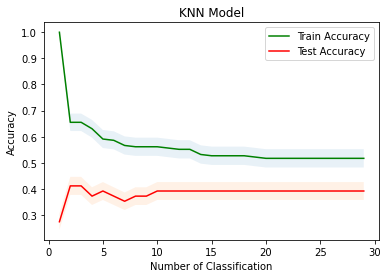

In [48]:
plt.plot(range(1, Ks), knn_mean_acc_train, 'g', label='Train Accuracy')
plt.fill_between(range(1, Ks), knn_mean_acc_train-1*knn_std_acc_train, knn_mean_acc_train+1*knn_std_acc_train, alpha=0.1)
plt.plot(range(1, Ks), knn_mean_acc_test, 'r', label='Test Accuracy')
plt.fill_between(range(1, Ks), knn_mean_acc_test-1*knn_std_acc_test, knn_mean_acc_test+1*knn_std_acc_test, alpha=0.1)
plt.title("KNN Model")
plt.xlabel("Number of Classification")
plt.ylabel("Accuracy")
plt.legend()

#### Retrieve the K value with highest accuracy.

In [49]:
best_K = np.argmax(knn_mean_acc_test)+1
print("The best K value for KNN in this case is: ", 
     best_K)

The best K value for KNN in this case is:  2


### Decision Tree

In [50]:
tree_depth = 20
tree_mean_acc = np.zeros((tree_depth))
for n in range(1, tree_depth+1):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=n, random_state=1).fit(X_train, y_train)
    yhat = tree.predict(X_test)
    tree_mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

Text(0, 0.5, 'Accuracy')

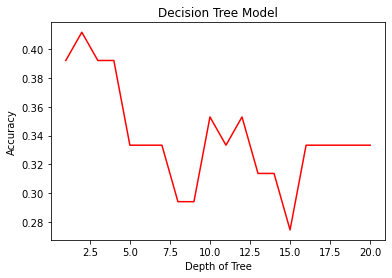

In [51]:
plt.plot(range(1, tree_depth+1), tree_mean_acc, 'r')
plt.title("Decision Tree Model")
plt.xlabel("Depth of Tree")
plt.ylabel("Accuracy")

#### Retrieve the Tree depth with the highest accuracy.

The best Tree Depth for Decision Tree model in this case is:  2


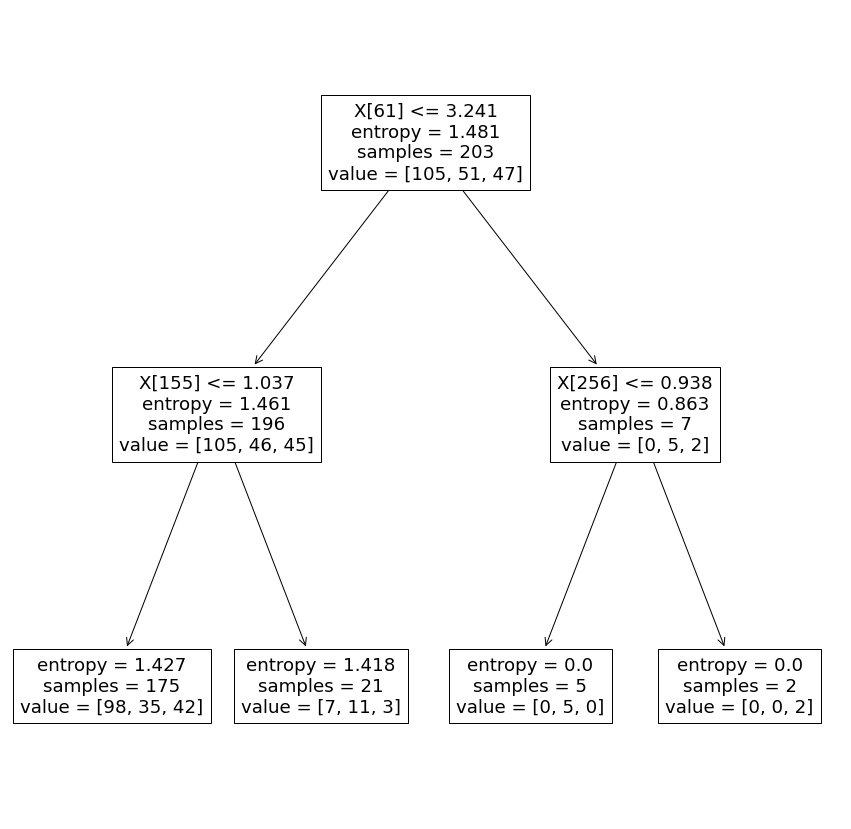

In [52]:
# Choose the best tree according to the graph above.
best_tree_depth = np.argmax(tree_mean_acc)+1
best_tree = DecisionTreeClassifier(criterion='entropy', max_depth=best_tree_depth, random_state=1).fit(X_train, y_train)
plt.figure(figsize=(15,15))
plot_tree(best_tree)
print("The best Tree Depth for Decision Tree model in this case is: ", 
     best_tree_depth)

### Support Vector Machine

In [53]:
max_c = 10
step = 1
svm_mean_acc_train = np.zeros((int(max_c / step)))
svm_mean_acc_test = np.zeros((int(max_c / step)))
for c_value in range(1, max_c+1):
    count = c_value
    c_value = c_value / 10
    support_vector = svm.SVC(kernel='rbf', random_state=1, gamma='scale', C=c_value).fit(X_train, y_train)
    yhat_train = support_vector.predict(X_train)
    yhat_test = support_vector.predict(X_test)
    svm_mean_acc_train[count-1] = metrics.accuracy_score(y_train, yhat_train)
    svm_mean_acc_test[count-1] = metrics.accuracy_score(y_test, yhat_test)

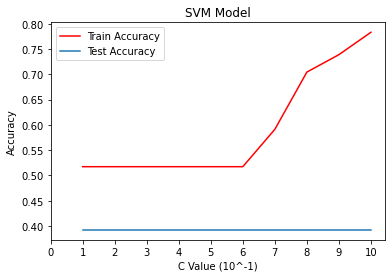

In [54]:
plt.plot(range(1, max_c+1), svm_mean_acc_train, 'r', label='Train Accuracy')
plt.plot(range(1, max_c+1), svm_mean_acc_test, label='Test Accuracy')
plt.title("SVM Model")
plt.xticks(np.arange(0, 11, 1))
plt.xlabel("C Value (10^-1)")
plt.ylabel("Accuracy")
plt.legend()

#### Retrieve the C-Value with the highest accuracy.

In [55]:
best_C_svm = (np.argmax(svm_mean_acc_test)+1)*(10**-1)
print("The best C-value for SVM in this case is: ", 
     best_C_svm)

The best C-value for SVM in this case is:  0.1


### Logistic Regression

In [56]:
max_c = 100
step = 1
lr_mean_acc_train = np.zeros((int(max_c / step)))
lr_mean_acc_test = np.zeros((int(max_c / step)))
for c_value in range(1, max_c+step):
    count = c_value
    c_value = c_value / 100
    log_reg = LogisticRegression(max_iter=1000, C=c_value, multi_class='multinomial', solver='saga', random_state=1).fit(X_train, y_train)
    yhat_train = log_reg.predict(X_train)
    yhat_test = log_reg.predict(X_test)
    lr_mean_acc_train[count-1] = metrics.accuracy_score(y_train, yhat_train)
    lr_mean_acc_test[count-1] = metrics.accuracy_score(y_test, yhat_test)

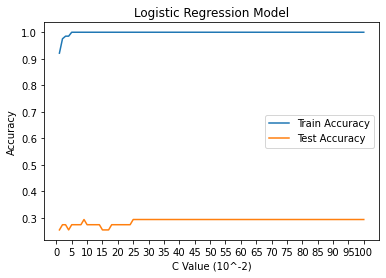

In [57]:
plt.plot(range(1, max_c+1), lr_mean_acc_train, label='Train Accuracy')
plt.plot(range(1, max_c+1), lr_mean_acc_test, label='Test Accuracy')
plt.title("Logistic Regression Model")
plt.xticks(np.arange(0, 105, 5))
plt.xlabel('C Value (10^-2)')
plt.ylabel('Accuracy')
plt.legend()

#### Retrieve C-Value with the best accuracy.

In [58]:
best_C_lr = (np.argmax(lr_mean_acc_test) + 1) * (10**-2)
print("The best C-value for Logistic Regression in this case is: ", 
     best_C_lr)

The best C-value for Logistic Regression in this case is:  0.09


## Model Evaluation using the best parameters for each model

#### Metrics:

* Jaccard Similarity Score
* F1-Score
* LogLoss

In [59]:
# Evaluation
testScores = {}

In [60]:
# KNN using the highest accuracy K as shown in the graph above.
best_knn = KNeighborsClassifier(n_neighbors=best_K, algorithm='auto').fit(X_train, y_train)
yhat_knn = best_knn.predict(X_test)
testScores['KNN-jaccard'] = jaccard_score(y_test, yhat_knn, average='weighted')
testScores['KNN-f1-score'] = f1_score(y_test, yhat_knn, average='weighted')

In [61]:
# Decision Tree using the highest accuracy Depth as shown in the graph above.
yhat_tree = best_tree.predict(X_test)
testScores['Tree-jaccard'] = jaccard_score(y_test, yhat_tree, average='weighted')
testScores['Tree-f1-score'] = f1_score(y_test, yhat_tree, average='weighted')

In [62]:
# SVM using the highest accuracy C Value as shown above.
best_svm = svm.SVC(kernel='rbf', random_state=1, gamma='scale', C=best_C_svm).fit(X_train, y_train)
yhat_svm = best_svm.predict(X_test)
testScores['SVM-jaccard'] = jaccard_score(y_test, yhat_svm, average='weighted')
testScores['SVM-f1-score'] = f1_score(y_test, yhat_svm, average='weighted')

In [63]:
# Logistic Regression using the highest accuracy C value.
best_lr = LogisticRegression(max_iter=1000, C=best_C_lr, multi_class='multinomial', solver='saga', random_state=1).fit(X_train, y_train)
yhat_lr = best_lr.predict(X_test)
yhat_lr_proba = best_lr.predict_proba(X_test)
testScores['LogReg-jaccard'] = jaccard_score(y_test, yhat_lr, average='weighted')
testScores['LogReg-f1-score'] = f1_score(y_test, yhat_lr, average='weighted')  
testScores['LogReg-logLoss'] = log_loss(y_test, yhat_lr_proba)

In [64]:
# KNN Evaluation
testScores

{'KNN-jaccard': 0.2054270624658532,
 'KNN-f1-score': 0.3130473241928351,
 'Tree-jaccard': 0.19039424280350437,
 'Tree-f1-score': 0.28243216478510597,
 'SVM-jaccard': 0.15378700499807765,
 'SVM-f1-score': 0.22093344380005525,
 'LogReg-jaccard': 0.17324531011805022,
 'LogReg-f1-score': 0.28966988893459483,
 'LogReg-logLoss': 1.9413222192393293}

In [65]:
report_df = pd.DataFrame({'Algorithm':['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'],
                          'Jaccard':[testScores['KNN-jaccard'],testScores['Tree-jaccard'],testScores['SVM-jaccard'],testScores['LogReg-jaccard']],
                          'F1-score':[testScores['KNN-f1-score'],testScores['Tree-f1-score'],testScores['SVM-f1-score'],testScores['LogReg-f1-score']],
                          'LogLoss':['NA', 'NA','NA',testScores['LogReg-logLoss']]})
report_df.set_index('Algorithm')
report_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.205427,0.313047,NA
1,Decision Tree,0.190394,0.282432,NA
2,SVM,0.153787,0.220933,NA
3,LogisticRegression,0.173245,0.289670,1.94132


#### Conclude: It is clear that among the four models above, KNN provides the best accuracy. Thus, moving forward, I will be using the KNN model to predict whether a venue will be a popular location to set up a Chinese Restaurant in New York City.

## Determine which venue would be Ideal for a Chinese Restaurant - New York City

### Preparing Data - Retrieve all Venues in NYC

In [66]:
# Retrieve all venues in New York City
def getAllVenues(boroughs, neighborhoods, latitudes, longitudes, radius=2000):
    LIMIT=200
    venues_list = []
    for borough, neighborhood, lat, lon in zip(boroughs, neighborhoods, latitudes, longitudes):
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&radius={}&v={}".format(
                CLIENT_ID,
                CLIENT_SECRET,
                lat,
                lon,
                radius,
                VERSION
                )
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(
            borough,
            neighborhood,
            lat,
            lon,
            v['venue']['id'],
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    column_names = ['Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue ID', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    all_venues = pd.DataFrame([item for venue in venues_list for item in venue], columns=column_names)

    return all_venues

In [67]:
all_venues = getAllVenues(boroughs=ny_dup_df['Borough'], neighborhoods=ny_dup_df['Neighborhood'], latitudes=ny_dup_df['Latitude'], longitudes=ny_dup_df['Longitude'])

In [68]:
all_venues

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Queens,Bay Terrace,40.782843,-73.776802,563c11e8cd1059cb26ede621,Stop & Shop,40.780143,-73.777895,Supermarket
1,Queens,Bay Terrace,40.782843,-73.776802,546ccdf2498e70143cc1430c,Dunkin',40.778697,-73.776876,Donut Shop
2,Queens,Bay Terrace,40.782843,-73.776802,4ac3a1a9f964a5201f9c20e3,Panera Bread,40.780701,-73.775668,Bakery
3,Queens,Bay Terrace,40.782843,-73.776802,4b8023c7f964a520cd5530e3,The Bay Terrace at Bayside,40.779110,-73.777177,Shopping Mall
4,Queens,Bay Terrace,40.782843,-73.776802,4c6707209cb82d7fd17792d2,The Health Nuts,40.778788,-73.778426,Gluten-free Restaurant
...,...,...,...,...,...,...,...,...,...
235,Staten Island,Sunnyside,40.612760,-74.097126,4c287cddce3fc9288f2d6d88,Dolphin Fitness Club,40.605351,-74.082943,Gym / Fitness Center
236,Staten Island,Sunnyside,40.612760,-74.097126,4dadc12093a070582bb6332a,SUBWAY,40.618939,-74.082881,Sandwich Place
237,Staten Island,Sunnyside,40.612760,-74.097126,4ba64b08f964a520254339e3,Staten Island Mini Golf & Battling Cages,40.609411,-74.119858,Mini Golf
238,Staten Island,Sunnyside,40.612760,-74.097126,4b1c37c8f964a5207b0424e3,The Home Depot,40.612988,-74.083782,Hardware Store


In [69]:
# Remove all duplicate venues
all_venues.drop_duplicates(subset=['Venue ID'], inplace=True)
all_venues.reset_index(drop=True, inplace=True)

In [70]:
all_venues

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Queens,Bay Terrace,40.782843,-73.776802,563c11e8cd1059cb26ede621,Stop & Shop,40.780143,-73.777895,Supermarket
1,Queens,Bay Terrace,40.782843,-73.776802,546ccdf2498e70143cc1430c,Dunkin',40.778697,-73.776876,Donut Shop
2,Queens,Bay Terrace,40.782843,-73.776802,4ac3a1a9f964a5201f9c20e3,Panera Bread,40.780701,-73.775668,Bakery
3,Queens,Bay Terrace,40.782843,-73.776802,4b8023c7f964a520cd5530e3,The Bay Terrace at Bayside,40.779110,-73.777177,Shopping Mall
4,Queens,Bay Terrace,40.782843,-73.776802,4c6707209cb82d7fd17792d2,The Health Nuts,40.778788,-73.778426,Gluten-free Restaurant
...,...,...,...,...,...,...,...,...,...
235,Staten Island,Sunnyside,40.612760,-74.097126,4c287cddce3fc9288f2d6d88,Dolphin Fitness Club,40.605351,-74.082943,Gym / Fitness Center
236,Staten Island,Sunnyside,40.612760,-74.097126,4dadc12093a070582bb6332a,SUBWAY,40.618939,-74.082881,Sandwich Place
237,Staten Island,Sunnyside,40.612760,-74.097126,4ba64b08f964a520254339e3,Staten Island Mini Golf & Battling Cages,40.609411,-74.119858,Mini Golf
238,Staten Island,Sunnyside,40.612760,-74.097126,4b1c37c8f964a5207b0424e3,The Home Depot,40.612988,-74.083782,Hardware Store


### Retrieve All Surrounding Venues for Each Venue

In [71]:
all_venues_nearby = getNearbyVenues(all_venues['Neighborhood'], all_venues['Venue ID'], all_venues['Venue Name'], all_venues['Venue Latitude'], all_venues['Venue Longitude'])

In [72]:
all_venues_nearby = all_venues_nearby.drop(axis=1, columns=['Restaurant ID', 'Restaurant Name'])
all_venues_nearby.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue ID', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

In [73]:
all_venues_nearby.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6749 entries, 0 to 6748
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            6749 non-null   object 
 1   Neighborhood Latitude   6749 non-null   float64
 2   Neighborhood Longitude  6749 non-null   float64
 3   Venue ID                6749 non-null   object 
 4   Venue                   6749 non-null   object 
 5   Venue Latitude          6749 non-null   float64
 6   Venue Longitude         6749 non-null   float64
 7   Venue Category          6749 non-null   object 
dtypes: float64(4), object(4)
memory usage: 421.9+ KB


In [74]:
all_venues_nearby

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Terrace,40.780143,-73.777895,563c11e8cd1059cb26ede621,Stop & Shop,40.780143,-73.777895,Supermarket
1,Bay Terrace,40.780143,-73.777895,546ccdf2498e70143cc1430c,Dunkin',40.778697,-73.776876,Donut Shop
2,Bay Terrace,40.780143,-73.777895,4b8023c7f964a520cd5530e3,The Bay Terrace at Bayside,40.779110,-73.777177,Shopping Mall
3,Bay Terrace,40.780143,-73.777895,4c6707209cb82d7fd17792d2,The Health Nuts,40.778788,-73.778426,Gluten-free Restaurant
4,Bay Terrace,40.780143,-73.777895,4ac3a1a9f964a5201f9c20e3,Panera Bread,40.780701,-73.775668,Bakery
...,...,...,...,...,...,...,...,...
6744,Sunnyside,40.608946,-74.087951,507c9fdee4b07113241f1937,Legally Blonde the Musical,40.614976,-74.094394,Theater
6745,Sunnyside,40.608946,-74.087951,4bc41a1cdce4eee163f0719d,Staten Island Motor Lodge,40.608381,-74.076692,Hotel
6746,Sunnyside,40.608946,-74.087951,4f2832fce4b054587a7bb628,Spiro Sports Center Gym,40.615470,-74.095453,Gym
6747,Sunnyside,40.608946,-74.087951,4f32362519836c91c7c122fb,Camelot Super Deli,40.600868,-74.092354,Food


In [75]:
# Remove all duplicated venues
all_venues_drop_dup = all_venues_nearby.drop_duplicates(subset='Venue ID')
all_venues_drop_dup.reset_index(inplace=True, drop=True)

In [76]:
all_venues_drop_dup

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Terrace,40.780143,-73.777895,563c11e8cd1059cb26ede621,Stop & Shop,40.780143,-73.777895,Supermarket
1,Bay Terrace,40.780143,-73.777895,546ccdf2498e70143cc1430c,Dunkin',40.778697,-73.776876,Donut Shop
2,Bay Terrace,40.780143,-73.777895,4b8023c7f964a520cd5530e3,The Bay Terrace at Bayside,40.779110,-73.777177,Shopping Mall
3,Bay Terrace,40.780143,-73.777895,4c6707209cb82d7fd17792d2,The Health Nuts,40.778788,-73.778426,Gluten-free Restaurant
4,Bay Terrace,40.780143,-73.777895,4ac3a1a9f964a5201f9c20e3,Panera Bread,40.780701,-73.775668,Bakery
...,...,...,...,...,...,...,...,...
1186,Sunnyside,40.609411,-74.119858,4f62f586d4f29a1f6ab80825,Redbox,40.612897,-74.128698,Video Store
1187,Sunnyside,40.612988,-74.083782,4c9b86e7db10b60c801f9c6d,Clove Road & Targee Street,40.607698,-74.089436,Intersection
1188,Sunnyside,40.612988,-74.083782,4bc41a1cdce4eee163f0719d,Staten Island Motor Lodge,40.608381,-74.076692,Hotel
1189,Sunnyside,40.612988,-74.083782,4e558bd845dd0a4826e7fbfc,MTA Bus - Narrows Rd N & St Johns Av (S79-SBS/...,40.606691,-74.075755,Bus Stop


In [77]:
# Onehot encode all Venue Categories to retrieve for each Venue, its surrounding venues.
all_venues_onehot = pd.get_dummies(all_venues_nearby[['Venue Category']], prefix= "", prefix_sep="")
all_venues_onehot.insert(loc=0, column='Venue Longitude', value=all_venues_nearby['Venue Longitude'])
all_venues_onehot.insert(loc=0, column='Venue Latitude', value=all_venues_nearby['Venue Latitude'])
all_venues_onehot.insert(loc=0, column='Venue', value=all_venues_nearby['Venue'])
all_venues_onehot.insert(loc=0, column='Venue ID', value=all_venues_nearby['Venue ID'])
all_venues_onehot.insert(loc=0, column='Neighborhood', value=all_venues_nearby['Neighborhood'])

In [78]:
all_venues_onehot

,Neighborhood,Venue ID,Venue,Venue Latitude,Venue Longitude,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Bay Terrace,563c11e8cd1059cb26ede621,Stop & Shop,40.780143,-73.777895,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bay Terrace,546ccdf2498e70143cc1430c,Dunkin',40.778697,-73.776876,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bay Terrace,4b8023c7f964a520cd5530e3,The Bay Terrace at Bayside,40.779110,-73.777177,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bay Terrace,4c6707209cb82d7fd17792d2,The Health Nuts,40.778788,-73.778426,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bay Terrace,4ac3a1a9f964a5201f9c20e3,Panera Bread,40.780701,-73.775668,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,Sunnyside,507c9fdee4b07113241f1937,Legally Blonde the Musical,40.614976,-74.094394,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6745,Sunnyside,4bc41a1cdce4eee163f0719d,Staten Island Motor Lodge,40.608381,-74.076692,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6746,Sunnyside,4f2832fce4b054587a7bb628,Spiro Sports Center Gym,40.615470,-74.095453,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6747,Sunnyside,4f32362519836c91c7c122fb,Camelot Super Deli,40.600868,-74.092354,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# Group all onehot encoded by the Venue ID.
temp_venues = all_venues_onehot.drop(axis=1, columns=['Neighborhood', 'Venue', 'Venue Latitude', 'Venue Longitude'])
all_venues_nearby_grouped = temp_venues.groupby('Venue ID').mean()
all_venues_nearby_grouped.reset_index(inplace=True)
all_venues_nearby_grouped.insert(loc=1, column='Venue Longitude', value=all_venues_drop_dup['Venue Longitude'])
all_venues_nearby_grouped.insert(loc=1, column='Venue Latitude', value=all_venues_drop_dup['Venue Latitude'])
all_venues_nearby_grouped.insert(loc=1, column='Venue Name', value=all_venues_drop_dup['Venue'])
all_venues_nearby_grouped.insert(loc=0, column='Neighborhood', value=all_venues_drop_dup['Neighborhood'])
all_venues_nearby_grouped

,Neighborhood,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Bay Terrace,3fd66200f964a52042e31ee3,Stop & Shop,40.780143,-73.777895,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bay Terrace,3fd66200f964a5209be41ee3,Dunkin',40.778697,-73.776876,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bay Terrace,3fd66200f964a520b1e91ee3,The Bay Terrace at Bayside,40.779110,-73.777177,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bay Terrace,3fd66200f964a520bfe31ee3,The Health Nuts,40.778788,-73.778426,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bay Terrace,3fd66200f964a520d7f11ee3,Panera Bread,40.780701,-73.775668,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,Sunnyside,5d9629652e04ea000834556a,Redbox,40.612897,-74.128698,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1187,Sunnyside,5dcaa0b73d8524000855920e,Clove Road & Targee Street,40.607698,-74.089436,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1188,Sunnyside,5dcaee4ef3d66f00071eaced,Staten Island Motor Lodge,40.608381,-74.076692,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1189,Sunnyside,5e8a0db5b0d6660008e3ddc7,MTA Bus - Narrows Rd N & St Johns Av (S79-SBS/...,40.606691,-74.075755,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
all_venues_nearby_grouped.describe()

,Venue Latitude,Venue Longitude,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,...,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,40.688278,-74.000593,0.000840,0.018472,0.000840,0.001679,0.011755,0.002519,0.001679,0.005877,...,0.001679,0.003359,0.002519,0.000840,0.000840,0.003359,0.002519,0.002519,0.005877,0.000840
std,0.083474,0.129534,0.028976,0.134707,0.028976,0.040962,0.107826,0.050146,0.040962,0.076471,...,0.040962,0.057880,0.050146,0.028976,0.028976,0.057880,0.050146,0.050146,0.076471,0.028976
min,40.534443,-74.197902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.604985,-74.113585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.742477,-74.001375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40.752508,-73.923250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,40.796541,-73.769168,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Set the prepared dataset to be input vector X for the classifier to predict its popularity as a Chinese Restaurant venue based on its surrounding venues

In [81]:
X_pred = all_venues_nearby_grouped.drop(axis=1, columns=['Neighborhood','Venue ID', 'Venue Name', 'Venue Latitude', 'Venue Longitude'])

In [82]:
# Match the columns of the X dataframe that is for prediction with that of the Feature set that was trained earlier.
for train_column in Feature.columns:
    if train_column not in X_pred.columns:
        X_pred.insert(loc=len(X_pred.columns), column=train_column, value=0)

for pred_column in X_pred.columns:
    if pred_column not in Feature.columns:
        X_pred = X_pred.drop(axis=1, columns=[pred_column])

In [83]:
X_pred

,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Track Stadium,Udon Restaurant,Ukrainian Restaurant,Vape Store,Varenyky restaurant,Veterinarian,Warehouse Store,Whisky Bar,Wine Shop,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1187,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1188,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
standard_scale = preprocessing.StandardScaler()
X_scaled = standard_scale.fit_transform(X_pred)
X_scaled

array([[-0.02898855, -0.1371842 , -0.02898855, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02898855, -0.1371842 , -0.02898855, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02898855, -0.1371842 , -0.02898855, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.02898855, -0.1371842 , -0.02898855, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02898855, -0.1371842 , -0.02898855, ...,  0.        ,
         0.        ,  0.        ],
       [-0.02898855, -0.1371842 , -0.02898855, ...,  0.        ,
         0.        ,  0.        ]])

### Predict Popularity of each Venue as a Chinese Restaurant based on Location

In [85]:
yhat = best_knn.predict(X_scaled)
yhat

array(['Average', 'Average', 'Average', ..., 'Average', 'Average',
       'Average'], dtype=object)

In [86]:
all_venues_nearby_grouped.insert(loc=len(all_venues_nearby_grouped.columns), column='Popularity', value=yhat)
venues_analyzed = all_venues_nearby_grouped

In [87]:
venues_analyzed

,Neighborhood,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Video Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Popularity
0,Bay Terrace,3fd66200f964a52042e31ee3,Stop & Shop,40.780143,-73.777895,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Average
1,Bay Terrace,3fd66200f964a5209be41ee3,Dunkin',40.778697,-73.776876,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Average
2,Bay Terrace,3fd66200f964a520b1e91ee3,The Bay Terrace at Bayside,40.779110,-73.777177,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Average
3,Bay Terrace,3fd66200f964a520bfe31ee3,The Health Nuts,40.778788,-73.778426,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Average
4,Bay Terrace,3fd66200f964a520d7f11ee3,Panera Bread,40.780701,-73.775668,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,Sunnyside,5d9629652e04ea000834556a,Redbox,40.612897,-74.128698,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Average
1187,Sunnyside,5dcaa0b73d8524000855920e,Clove Road & Targee Street,40.607698,-74.089436,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Popular
1188,Sunnyside,5dcaee4ef3d66f00071eaced,Staten Island Motor Lodge,40.608381,-74.076692,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Average
1189,Sunnyside,5e8a0db5b0d6660008e3ddc7,MTA Bus - Narrows Rd N & St Johns Av (S79-SBS/...,40.606691,-74.075755,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Average


## Visualize New York Map with Ideal and Poor Locations for setting up Chinese Restaurants

In [88]:
potential_chinese_restaurant = venues_analyzed.loc[venues_analyzed['Popularity']=='Popular']
potential_chinese_restaurant.reset_index(drop=True, inplace=True)

In [89]:
potential_chinese_restaurant

,Neighborhood,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Video Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Popularity
0,Bay Terrace,407f2200f964a5207df21ee3,Boston Market,40.780246,-73.776820,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Popular
1,Bay Terrace,42829c80f964a5206a221fe3,Victoria's Secret,40.779104,-73.776631,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Popular
2,Bay Terrace,45940e37f964a52055401fe3,Verizon,40.779437,-73.776643,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Popular
3,Bay Terrace,49f33380f964a5206d6a1fe3,NYC Greenway - Queens North Shore,40.789824,-73.786260,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Popular
4,Bay Terrace,49f4b70bf964a5203e6b1fe3,Rainbow Kiss Salon And Spa,40.788562,-73.785677,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Popular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,Sunnyside,5c421048dbde11002535721b,Manor Restaurant,40.604350,-74.120644,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Popular
158,Sunnyside,5c88fc9e9b0473002cc3dba7,Staten Island Diner,40.612962,-74.126320,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Popular
159,Sunnyside,5ce409f7054e29002c08e7b0,Tokyo Sushi Japanese,40.613121,-74.120907,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Popular
160,Sunnyside,5cfeaedba8eb600039a444cc,SUBWAY,40.612516,-74.129302,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Popular


In [90]:
# Create a map of New York City with venues that are likely to be popular
# for a chinese restaurant superimposed on top.
map_ny = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)
for lat, lon, venue in zip(potential_chinese_restaurant['Venue Latitude'], potential_chinese_restaurant['Venue Longitude'],  potential_chinese_restaurant['Venue Name']):
    label = "{}, popular".format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location=[lat, lon],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#3186cc',
                       fill_opacity=0.7,
                       parse_html=True).add_to(map_ny)

map_ny

In [91]:
avoid_venues = venues_analyzed.loc[venues_analyzed['Popularity']=='Unpopular']
avoid_venues.reset_index(drop=True, inplace=True)

In [92]:
avoid_venues

,Neighborhood,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Accessories Store,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Video Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Popularity
0,Bay Terrace,42ffdb00f964a520f5261fe3,LOFT,40.780669,-73.775622,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unpopular
1,Bay Terrace,43695300f964a5208c291fe3,Duane Reade,40.778987,-73.775963,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unpopular
2,Bay Terrace,4b19bf81f964a52050e323e3,Starbucks,40.768705,-73.791991,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unpopular
3,Bay Terrace,4b64ed10f964a52031da2ae3,Dance Sensations Dance Studio,40.542302,-74.146263,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unpopular
4,Chelsea,4bc7990c15a7ef3b17bb79da,London Terrace Gardens Courtyard,40.747886,-74.003224,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Unpopular
5,Chelsea,4c0698158a81c9b660f52590,Chelsea Piers Great Lawn,40.749757,-74.009414,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Unpopular
6,Chelsea,4ca0aa5546978cfabc6bb57f,MTA Bus - Victory Bl & Wild Av (S62/S92),40.587325,-74.197902,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Unpopular
7,Murray Hill,4d0528c5347da1cdb88a2f8f,The Raines Law Room at The William,40.750487,-73.980146,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unpopular
8,Sunnyside,5bb00b1d35f983002c80ed81,Joe & Pat Pizzeria and Restaurant,40.613046,-74.122128,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Unpopular


In [93]:
# Superimpose venues to avoid with the color red when setting up a Chinese Restaurant in New York City
for lat, lon, venue in zip(avoid_venues['Venue Latitude'], avoid_venues['Venue Longitude'], avoid_venues['Venue Name']):
    label = "{}, unpopular".format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(location=[lat, lon],
                       radius=5,
                       popup=label,
                       color='red',
                       fill=True,
                       fill_color='red',
                       fill_opacity=0.7,
                       parse_html=True).add_to(map_ny)

In [94]:
map_ny

## Conclusion

Notice from the map above that for each neighborhood, there are both great locations and poor locations to setup a Chinese Restaurant. That said, the accuracy of predicting a location's popularity based on its nearby locations seems to be an arduous and inaccurate task as shown from the low accuracies above. The low accuracy could be due to a lack of dataset and limitations of the Foursquare API in getting a precise value of 'Likes' for each restaurant.

I would also have to admit that simply taking the top 25 percent most 'Likes' from the Chinese Restaurant dataframe and setting it as 'Popular' for the outcome vector, y is not going to be a good gauge on whether a Chinese Restaurant is popular. 

One such reason is that different restaurants would attract different demographics of people. This means that some restaurants would be more catered towards younger, more tech-savvy customers which may be more inclined to 'Like' a chinese restaurant on social media. Moreover, there are other factors like a restaurant's intentional efforts to boosting its likes by giving freebies to customers who 'Like' the restaurant on social media. Other factors that could've affected a restaurant's 'Likes' count, rendering the 'Likes' metric for popularity to be inaccurate, could be the duration for which the restaurant have existed. For instance, a restaurant which may have started 2 years ago would definitely have more likes than a newly setup restaurant. This does not necessarily mean that the location of the new restaurant is bad and hence it has lesser likes as it would take time for people to notice its existence and to gain popularity.

Thus, based on these reasons, while a restaurant's 'Likes' count may be high, it does not necessarily mean that they are popular.

## Further Work

To address the factor that different restaurants attract different demographics of people, one logical approach to reducing this inaccuracy could be training the model on similar restaurants in terms of appeal to the kind of demographics. For example, comparing a Chinese Si Chuan Delicacy Restaurant in Bay Terrace neighborhood with another Chinese Si Chuan Delicacy Restaurant in Sunnyside neighborhood. This would reduce the other variables in the training set, narrowing the effects of a change in popularity such that it is only due to a restaurant's location.

Addressing the factor that a restaurant may have began earlier would be as simple as retrieving a restaurant's start date and only feeding Chinese Restaurants with similar start dates to train the classification model. However, doing so may lead to insufficient dataset. Instead, I would recommend to use 'Likes' from restaurants that are fairly new (perhaps within a year old - more experiments need to be done) as doing so would limit other variables such as consumers growing a preference for the restaurant and hence coming back often rather than due to its location, which is what we are trying to predict here. Thus, limiting the 'Likes' such that we are only retrieving the starting phase of a restaurant would mean that most customers are only going there because of its location as they do not yet know whether the restaurant's quality of food appeals to their personal preferences.